In [1]:
#sciezka z danymi
%cd "C:\Users\Dawid\Desktop\kurs\jdszr4-animalsi\wino"

C:\Users\Dawid\Desktop\kurs\jdszr4-animalsi\wino


In [8]:
#glowne biblioteki
import pandas as pd
import numpy as np 
from xgboost import XGBClassifier, DMatrix, cv
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV, StratifiedKFold,  train_test_split
from sklearn.preprocessing import LabelEncoder
from time import time 
import matplotlib.pyplot as plt
from winsound import Beep

In [17]:
#wlasny modul
from dane.dane_wsadowe_zmiana_klas import *

lista zmiennych: 
 ['X', 'Y', 'X_train_all', 'X_test', 'Y_train_all', 'Y_test', 'X_train_reduced', 'X_val', 'Y_train_reduced', 'Y_val', 'X_train_all_scaled', 'X_test_scaled', 'X_val_scaled', 'X_train_reduced_scaled', 'X_train_all_scaled_PCA', 'X_test_scaled_PCA', 'X_train_reduced_scaled_PCA', 'X_val_scaled_PCA']


**1. Prosty model XGboost jako benchmark**

a) dane nieprzetworzone

In [22]:
#wyjdzmy od prostego modelu na domyslnych parametrach
model_xgb1 = XGBClassifier(objective= 'binary:logistic',eval_metric='mlogloss')
model_xgb1.fit(X_train_reduced,Y_train_reduced)
pred_xgb1 = model_xgb1.predict(X_val)

#ocena modelu na danych treningowych i testowych 
print("acc train: ",round(model_xgb1.score(X_train_reduced, Y_train_reduced),4), "\n",
      "acc val: ", round(model_xgb1.score(X_val, Y_val),4))


acc train:  1.0 
 acc val:  0.9297


In [23]:
#ocena jakosci modelu nr 1
xgb1_cnf_matrix = confusion_matrix(Y_val, pred_xgb1)
xgb1_cnf_raport = classification_report(Y_val, pred_xgb1)
print(xgb1_cnf_raport)
print(xgb1_cnf_matrix)

              precision    recall  f1-score   support

           1       0.96      0.97      0.96       116
           2       0.64      0.58      0.61        12

    accuracy                           0.93       128
   macro avg       0.80      0.77      0.79       128
weighted avg       0.93      0.93      0.93       128

[[112   4]
 [  5   7]]


Model na podstawowych parametrach całkiem dobrze przewiduje klasę 2, perfekcyjnie klasę 1. 
Spróbujmy dalej

b) dane przeskalowane

In [24]:
#wyjdzmy od prostego modelu na domyslnych parametrach
model_xgb2 = XGBClassifier(objective= 'binary:logistic',eval_metric='mlogloss')
model_xgb2.fit(X_train_reduced_scaled,Y_train_reduced)
pred_xgb2 = model_xgb2.predict(X_val_scaled)


#ocena modelu na danych treningowych i testowych 
print("acc train: ",round(model_xgb2.score(X_train_reduced_scaled, Y_train_reduced),4), "\n",
      "acc val: ", round(model_xgb2.score(X_val_scaled, Y_val),4))

acc train:  1.0 
 acc val:  0.9297


In [25]:
#ocena jakosci modelu nr 2
xgb2_cnf_matrix = confusion_matrix(Y_val, pred_xgb2)
xgb2_cnf_raport = classification_report(Y_val, pred_xgb2)
print(xgb2_cnf_raport)
print(xgb2_cnf_matrix)

              precision    recall  f1-score   support

           1       0.96      0.97      0.96       116
           2       0.64      0.58      0.61        12

    accuracy                           0.93       128
   macro avg       0.80      0.77      0.79       128
weighted avg       0.93      0.93      0.93       128

[[112   4]
 [  5   7]]


Standaryzacja w tym przypadku nie poprawia w ogóle naszego dopasowania.

c) dane PCA

In [26]:
#wyjdzmy od prostego modelu na domyslnych parametrach
model_xgb3 = XGBClassifier(objective= 'binary:logistic',eval_metric='mlogloss')
model_xgb3.fit(X_train_reduced_scaled_PCA,Y_train_reduced)
pred_xgb3 = model_xgb3.predict(X_val_scaled_PCA)

#ocena modelu na danych treningowych i testowych 
print("acc train: ",round(model_xgb3.score(X_train_reduced_scaled_PCA, Y_train_reduced),4), "\n",
      "acc val: ", round(model_xgb3.score(X_val_scaled_PCA, Y_val),4))

acc train:  1.0 
 acc val:  0.8984


In [27]:
#ocena jakosci modelu nr 3
xgb3_cnf_matrix = confusion_matrix(Y_val, pred_xgb3)
xgb3_cnf_raport = classification_report(Y_val, pred_xgb3)
print(xgb3_cnf_raport)
print(xgb3_cnf_matrix)

              precision    recall  f1-score   support

           1       0.94      0.95      0.94       116
           2       0.45      0.42      0.43        12

    accuracy                           0.90       128
   macro avg       0.70      0.68      0.69       128
weighted avg       0.89      0.90      0.90       128

[[110   6]
 [  7   5]]


W przypadku tego modelu widzimy, że PCA nie wpływa na jakość analiz dla podstawowych parametrów. 
W dalszej część będziemy posługiwać sie danym standaryzowanymi

**2. Znajdzmy najlepsze parametry dla tego modelu**

In [4]:
#zacznijmy od małego zestawu, by dostrzec czy jest w ogóle jakas poprawa 
params_xgb1 = {"max_depth"        :list(range(2, 15, 2)),
              "n_estimators"      :list(range(50,211,40)),
              "learning_rate"     :list(np.linspace(0.05,0.40, 8)),
               
}

In [62]:
r=  0   # policzymy ile jest mozliwych kombinacji parametrow
for j in params_xgb1.values():
    s=len(j)
    r += s
r

20

In [65]:
#zdefiniujmy obiekt sprawdzajacy nasze parametry
model_xgb4 = XGBClassifier(objective= "multi:softmax", booster = "gbtree",n_jobs = 3,eval_metric='mlogloss')
skf = StratifiedKFold(n_splits=5, shuttle = True)
grid_search1 =  GridSearchCV(model_xgb4,param_grid = params_xgb1,cv =5,verbose = 1,scoring = make_scorer(balanced_accuracy_score)).fit(X_train_all_scaled,Y_train_all)
Beep(400,1000)

Fitting 5 folds for each of 280 candidates, totalling 1400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Dawid\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed: 16.6min finished


In [68]:
# sprawdzmy nasz najlepszy zestaw parametrow
print(grid_search1.best_params_)

model_xgb4 = grid_search1.best_estimator_
model_xgb4.fit(X_train_all_scaled,Y_train_all)

pred_xgb4 = model_xgb4.predict(X_test_scaled)

{'learning_rate': 0.2, 'max_depth': 14, 'n_estimators': 50}


In [69]:
#ocena jakosci modelu z wybranymi najlepszymi parametrami
xgb4_cnf_matrix = confusion_matrix(Y_test, pred_xgb4)
xgb4_cnf_raport = classification_report(Y_test, pred_xgb4)
print(xgb4_cnf_raport)
print(xgb4_cnf_matrix)

              precision    recall  f1-score   support

           1       0.50      0.14      0.22         7
           2       0.88      0.96      0.92       260
           3       0.72      0.49      0.58        53

    accuracy                           0.86       320
   macro avg       0.70      0.53      0.58       320
weighted avg       0.85      0.86      0.85       320

[[  1   6   0]
 [  1 249  10]
 [  0  27  26]]


Nasz model uzyskał wysoki współczynnik f1-score dla klasy 2, jednak dla pozostałych klas współczynniki nadal są niskie.

**Spróbujmy wykorzystać walidacje wskrośną (Cross validacje) wbudowana w pakiecie XGboost**

In [180]:
#Najpierw przetworzmy dane do wlasciwego formatu:

#przerobmy nasze Y za pomoca LabelEncodera
LE = LabelEncoder()
Y_train_all_encoded = LE.fit_transform(Y_train_all)
Y_test_encoded = LE.fit_transform(Y_test)


dane = DMatrix(data = X_train_all_scaled, label = Y_train_all_encoded)

params_xgb2 = {"max_depth"        :14,
              "learning_rate"     :0.2,
              "booster"           :"gbtree",
              "objective"         :"multi:softmax",
              "num_class"         : 3
}


model_xgb5 = cv(dtrain = dane, params = params_xgb2, nfold = 5,num_boost_round=100,
                metrics = "auc", as_pandas = True,early_stopping_rounds = 5)

In [169]:
model_xgb5.columns

Index(['train-auc-mean', 'train-auc-std', 'test-auc-mean', 'test-auc-std'], dtype='object')

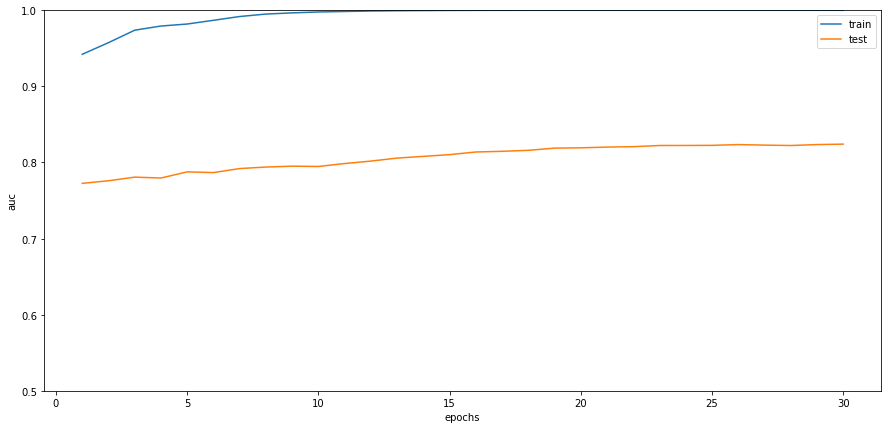

In [181]:
#zobrazujmy nasz proces trenowania na podstawie AUC

train_auc = model_xgb5.iloc[::,0]
test_auc = model_xgb5.iloc[::,2]
y_axis = range(1,model_xgb5.shape[0]+1)

plt.figure(figsize=(15, 7))
plt.plot(y_axis,train_auc, label = "train")
plt.plot(y_axis,test_auc, label = "test")
plt.xlabel("epochs")
plt.ylabel("auc")
plt.ylim([0.5, 1])
plt.legend()
_=plt.show()

Rowniez metoda z cross walidacja nie przynosi wyzsze jakosci klasyfikacji.


In [11]:
# dobierzmy jeszcze do naszego najlepszego modelu najbardziej optymalny zestaw parametrów i spróbujmy z inna metoda walidacji i innym scoremem
params_xgb2 = {"max_depth"        :list(range(11, 15, 1)),
              "n_estimators"      :list(range(50,211,40)),
              "learning_rate"     :list(np.linspace(0.1,0.40, 5)),
               'objective'        :["multi:softmax", "multi:softprob"]
}



In [12]:
#zdefiniujmy obiekt sprawdzajacy nasze parametry
model_xgb5 = XGBClassifier(booster = "gbtree",n_jobs = 3,eval_metric='mlogloss')
skf = StratifiedKFold(n_splits=5, shuffle = True)
grid_search2 =  GridSearchCV(model_xgb5,param_grid = params_xgb2,cv =skf,verbose = 1,scoring = make_scorer(balanced_accuracy_score)).fit(X_train_all_scaled,Y_train_all)
Beep(400,1000)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Dawid\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed: 13.1min finished


In [15]:
# sprawdzmy nasz najlepszy zestaw parametrow
print(grid_search2.best_params_)

model_xgb5 = grid_search2.best_estimator_
model_xgb5.fit(X_train_all_scaled,Y_train_all)

pred_xgb5 = model_xgb5.predict(X_test_scaled)

{'learning_rate': 0.4, 'max_depth': 13, 'n_estimators': 210, 'objective': 'multi:softmax'}


In [16]:
#ocena jakosci modelu z wybranymi najlepszymi parametrami
xgb5_cnf_matrix = confusion_matrix(Y_test, pred_xgb5)
xgb5_cnf_raport = classification_report(Y_test, pred_xgb5)
print(xgb5_cnf_raport)
print(xgb5_cnf_matrix)

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        12
           2       0.89      0.96      0.92       267
           3       0.72      0.56      0.63        41

    accuracy                           0.87       320
   macro avg       0.54      0.51      0.52       320
weighted avg       0.84      0.87      0.85       320

[[  0  12   0]
 [  3 255   9]
 [  0  18  23]]


To na nic, klasa 1 wciąż uzyskuje niesatysfakcjonujace wyniki, sprobujmy przerobic nasz zbior na binarna klasyfikacje